The 600 first epochs were performed on the reduce dataset (360 000 images). Then to the complete dataset (560 000 images).

With batch size of 640 and 360 000 images in the database, 100 epochs took about 3h (a bit less)
With batch size of 700 and 560 000 images in the database, 100 epochs took about 4h40


WITH METRICS: 200 epochs: Wall time: 11h 33min 22s

Current script load the 'final' weigths (which is save if everything goes well)

Weights are saved every 100 epochs. I should probably keep wieghts each 1000 epochs (depending on how many time it took to treat the whole data set) 139298/139937


Look at the correlation matrix to see if there is a bias in the angle correct prediction. If yes, rebuild the dataset by applying angle of 90/180/270 to try to get something mor or less homogenous
1 step: realign every centriole in a 0->90 orientation

2ns step: perform reorientation. => rotation of 90/180/270 i can also flip the image

Load the 500 epochs save if problem



TO DO:

To check: Note: in train definition i put the model in train mode (model.train() ) I do not change this statut after.

Save the log of accuracy and loss

Save the train_loader and validation_loader to don't have to rebuild them (especially because that lead to mixing each time train and validation set


IMPORTANT: CHANGE PERFORMED ON gestion of classification/Regression problem (modification of n_classes/n_class call in data_agregator and VGG_schmidtea to modify the call of the number of class. MODIFICATION NOT TESTED


In [1]:
import torch
import torch.nn as nn
import numpy as np
import csv

import import_ipynb

from tools.ToolBox import json_loader
from tools.ToolBox import csv_saver

from tools.CNN_Tools import VGG_Schmidtea
from tools.CNN_Tools import train
from tools.CNN_Tools import validate

from tools.Dataset_Tools import centriole_dataset
from tools.Dataset_Tools import dataset_creator
from tools.Dataset_Tools import dataset_loader
from tools.Dataset_Tools import dataset_aggregator

importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\ToolBox.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\CNN_Tools.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Dataset_Tools.ipynb


In [2]:
problem = 'regression'
problem = 'classification'


if problem == 'classification':
    n_class = 72
    
else:
    n_class = 1

In [3]:
load_dataset = True

# Creation/Loading of the Dataset
if load_dataset == False:   
    train_loader, validation_loader = dataset_creator(path_json = './data_json/',
                                                     batch_size = 700,
                                                     n_class = n_class,
                                                     save_dataset = True)  
elif problem == 'classification':
    train_loader, validation_loader = dataset_loader(path = './data/',
                                                     #train_set = 'train_loader_dataset_b700_unNormalized.pth',
                                                     train_set = 'train_data_pregression_b700_unNormalized-003.pth',
                                                     #val_set = 'validation_loader_dataset_b700_unNormalized.pth')
                                                     val_set = 'validation_data_pregression_b700_unNormalized.pth')
    
else: 
    train_loader, validation_loader = dataset_loader(path = './data/',
                                                 #train_set = 'train_data_pregression_b700_unNormalized.pth',
                                                 train_set = 'data_train_regression_normalized.pth',
                                                 val_set = 'validation_data_pregression_b700_unNormalized.pth')


In [5]:
load_weight = False


if torch.cuda.is_available():                                  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)


# Criterion and CNN loading
if problem == 'classification':
    criterion = nn.CrossEntropyLoss()
    model = VGG_Schmidtea(n_classes = n_class).to(device)
else: 
    criterion = nn.MSELoss()
    model = VGG_Schmidtea(n_classes = 1).to(device)


# Weight loading
if load_weight == True:
    model.load_state_dict(torch.load('./weight/VGG_schmidtea_weight_classification.pth'))


# Oprimizer loading
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)


Using PyTorch version: 1.6.0+cpu  Device: cpu


In [6]:
%%time

# Define the number of epochs to train the model
epochs = 1
performed_epochs = 0


# Let's Train!!
for epoch in range(1, epochs + 1):
    # Instantiate variable to log loss and accuracy
    acct, losst, accv, lossv,cmt, cmv  = [], [], [], [], [], []
    
    train(model, losst, acct, cmt, train_loader, device, problem, criterion, optimizer, epoch, n_class)    
    validate(model, lossv, accv, cmv, validation_loader, device, problem, criterion, n_class)
    
    if epoch%100 == 0:
        torch.save(model.state_dict(),('./weight/VGG_schmidtea_weigth_epoch_regression_normalized' + str(epoch+performed_epochs) + '.pth'))
    if epoch%10 == 0:
        torch.save(model.state_dict(),('./weight/VGG_schmidtea_weigth_epoch_regression_tmp.pth'))
        last_tmp_save = epoch + performed_epochs

    
    
    csv_saver(accv , './metrics/accv.csv')
    csv_saver(lossv, './metrics/lossv.csv')
    csv_saver(acct , './metrics/acct.csv')
    csv_saver(losst, './metrics/losst.csv')
    csv_saver(cmt  , './metrics/cmt.csv')
    csv_saver(cmv  , './metrics/cmv.csv')
    
    
#torch.save(model.state_dict(),('VGG_schmidtea_weigth_epoch_final.pth'))

IndexError: Target 306 is out of bounds.

# ADD CONFUSION MATRIX IN REGISTERED METRICS

In CNN_TOOLS , add conf_matrix as arguments and add the arguments here too

In [10]:
confusion_matrix = torch.zeros(n_class, n_class)

#model.load_state_dict(torch.load('./weight/VGG_schmidtea_weigth_epoch_regression1500.pth'))
model.load_state_dict(torch.load('./weight/VGG_schmidtea_weight_classification.pth', map_location = device))


for batch_idx, batch in enumerate(validation_loader):
    # Copy data to GPU if needed
    img = batch['image'].float().to(device)
    angle = batch['angle'].long().to(device)
    angle = angle // 5
    
    with torch.no_grad():   
        output = model(img)  

    # get the index of the max log-probability
    pred_angle = output.max(1)[1]

    for a, p in zip(angle.view(-1), pred_angle.view(-1)):
        confusion_matrix[a.long(), p.long()] +=1
            
# Data in %
col_sum = confusion_matrix.numpy().sum(axis=1)
col_sum = np.reshape(col_sum, [n_class, -1])

confusion_matrix = confusion_matrix / col_sum
    
df_cm = pd.DataFrame(confusion_matrix.numpy())

plt.figure(figsize = (12,8))
sn.heatmap(df_cm)

NameError: name 'pd' is not defined

In [15]:
for batch_idx, batch in enumerate(validation_loader):
    print(batch['image'].size())

torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([700, 1, 32, 32])
torch.Size([70

<AxesSubplot:ylabel='Count'>

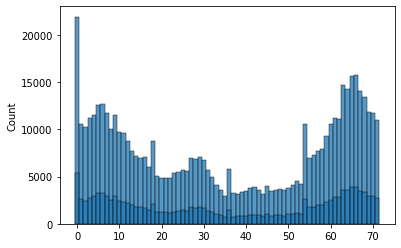

In [87]:
class_72 = np.zeros(72)
classes = np.linspace(0,71, 72, dtype = np.int16)

for i in train_loader:
    for j in i['angle']:
        class_72[int(j.numpy()//5)] += 1
        
import seaborn as sns

sns.histplot(x = classes, weights = class_72, discrete =  True)

class_72 = np.zeros(72)
classes = np.linspace(0,71, 72, dtype = np.int16)

for i in validation_loader:
    for j in i['angle']:
        class_72[int(j.numpy()//5)] += 1
        
import seaborn as sns

sns.histplot(x = classes, weights = class_72, discrete =  True)

In [72]:
classes = np.linspace(0,71, 72, dtype= np.int16)
first_degre = np.linspace(0, 355, 72, dtype = np.int16)
second_degre = np.linspace(5,360,72, dtype = np.int16)

#for i in range(len(classes)):
# print("{} = {}->{}".format(classes[i], first_degre[i], second_degre[i]))

dist = int(len(classes)/4)
for i in range(dist):
    print("{} = {}->{}     {} = {}->{}     {} = {}->{}     {} = {}->{}".format(classes[i], first_degre[i], second_degre[i],
                                                                              classes[i+dist], first_degre[i+dist], second_degre[i+dist],
                                                                              classes[i+2*dist], first_degre[i+2*dist], second_degre[i+2*dist],
                                                                              classes[i+3*dist], first_degre[i+3*dist], second_degre[i+3*dist]))

0 = 0->5     18 = 90->95     36 = 180->185     54 = 270->275
1 = 5->10     19 = 95->100     37 = 185->190     55 = 275->280
2 = 10->15     20 = 100->105     38 = 190->195     56 = 280->285
3 = 15->20     21 = 105->110     39 = 195->200     57 = 285->290
4 = 20->25     22 = 110->115     40 = 200->205     58 = 290->295
5 = 25->30     23 = 115->120     41 = 205->210     59 = 295->300
6 = 30->35     24 = 120->125     42 = 210->215     60 = 300->305
7 = 35->40     25 = 125->130     43 = 215->220     61 = 305->310
8 = 40->45     26 = 130->135     44 = 220->225     62 = 310->315
9 = 45->50     27 = 135->140     45 = 225->230     63 = 315->320
10 = 50->55     28 = 140->145     46 = 230->235     64 = 320->325
11 = 55->60     29 = 145->150     47 = 235->240     65 = 325->330
12 = 60->65     30 = 150->155     48 = 240->245     66 = 330->335
13 = 65->70     31 = 155->160     49 = 245->250     67 = 335->340
14 = 70->75     32 = 160->165     50 = 250->255     68 = 340->345
15 = 75->80     33 = 165->

=======================================

In [11]:
#dataset_train = centriole_dataset(img_db = x_train, angle_db = y_train)
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(len(dataset_train)):
    sample = dataset_train[i+10]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('angle {}°'.format(int(sample['angle'])))
    ax.axis('off')
    show_centriole(np.array(sample['image'], dtype = 'uint8'))

    if i == 3:
        plt.show()
        break


NameError: name 'dataset_train' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
dataset_test = centriole_dataset(img_db = x_test, angle_db = y_test)


fig = plt.figure()

for i in range(len(dataset_test)):
    sample = dataset_test[i+10]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('angle {}°'.format(int(sample['angle'])))
    ax.axis('off')
    show_centriole(np.array(sample['image'], dtype = 'uint8'))

    if i == 3:
        plt.show()
        break
